In [1]:
# Import library (ライブラリのインポート)
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from skimage.io import imsave


In [3]:
# Mount on google drive (ドライブにマウント)
# skip this cell if you run this code on your local PC (ローカルで実行する場合はこのセルをスキップ)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/GeoMAC-main' # @param{type:"string"}
os.chdir(drive_path)

# Preparation
1. Create a new folder in `/data` directory 
(`/data` ディレクトリ内に新しいフォルダを作成)

1. Rename the new folder to sample name 
(フォルダの名前をサンプル名にする)

1. Place grayscale images of mapping data to the new folder 
(作成したフォルダ内にグレースケールのマッピング画像を置く)

# Read data (データの読み込み)

In [2]:
#@markdown Folder name under `/data` folder (`/data` 内のフォルダ名)
sample_name = '001' # @param{type:"string"}

###########
# Confirm the folder (データフォルダが存在するか確認)
datadir = f"data/{sample_name}"
assert os.path.exists(datadir), f"path not exists: {datadir}"
# Creating new folder to export image data (画像を書き出すフォルダを作成)
savedir = f"out/{sample_name}"
if os.path.exists(savedir):
    print(f"CHECK! Savedir already exists: {savedir}")
    print('Existing files may be overwritten')
os.makedirs(savedir, exist_ok = True)

CHECK! Savedir already exists: out/001
Existing files may be overwritten


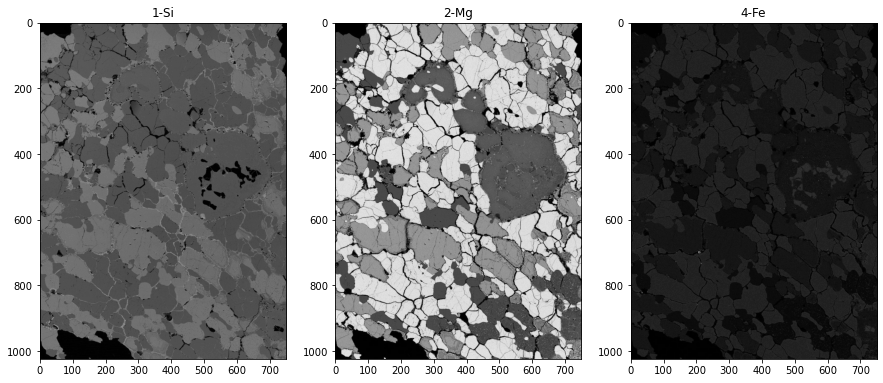

In [3]:
#@markdown List image names (画像のファイル名を列挙)　
elements = ['1-Si', '2-Mg', '4-Fe'] # @param{type:"raw"}
#@markdown File extension (ファイルの拡張子)
ext = '.jpg' # @param{type:"string"}

# Acquire data and reconstruct image (データを取得して画像で表示)
fig, ax = plt.subplots(1, len(elements), figsize = (15, 7))
plt.gray()
flatten_arrays = {}

for i, e in enumerate(elements):
    img_path = f"data/{sample_name}/{e}{ext}"
    assert os.path.exists(img_path), f"path not exists: {img_path}"
    img_k = cv2.imread(img_path, 0)
    flatten_arrays[e] = np.array(img_k).flatten()

    ax[i].imshow(img_k)
    ax[i].set_title(e)
    ax[i].set_aspect('equal')

savepath = f"out/{sample_name}/01_elemental_distribution_map.jpg"
plt.savefig(savepath)
plt.show()
df_flat = pd.DataFrame(flatten_arrays)

# Option: Creating map by elemental ratio (元素比マップ）

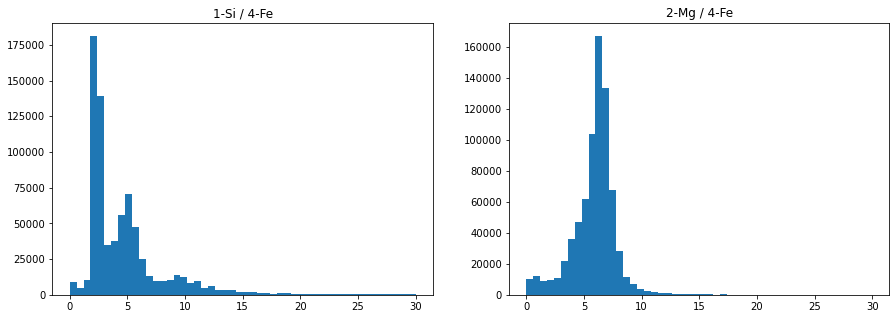

In [4]:
pairs = [('1-Si', '4-Fe'), ('2-Mg', '4-Fe')]
# Define data ranges with referring below histograms (ヒストグラムを見ながら範囲を決定)
# Start at (0, 255) to look through full data range (最初は (0, 255) で設定し，グラフを見ながら絞り込む)
ranges = [(0, 30), (0, 30)] 

###########
fig, ax = plt.subplots(1, len(pairs), figsize = (15, 5))
for i, p in enumerate(pairs):
    ax[i].hist(df_flat[p[0]] / df_flat[p[1]], range=ranges[i], bins=50)
    ax[i].set_title(' / '.join(list(p)))
plt.show()

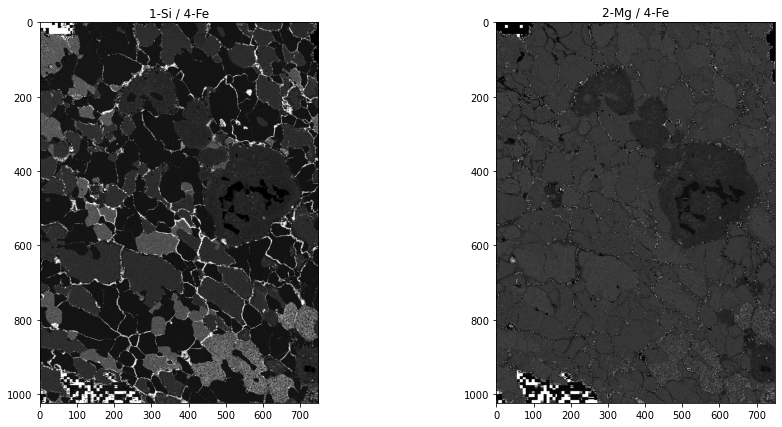

In [5]:
# Map by elemental ratio (元素比のマッピング)
# using range defined at the above cell

fig, ax = plt.subplots(1, len(pairs), figsize = (15, 7))
plt.gray()
for i, p in enumerate(pairs):
    img_ratio = np.array(df_flat[p[0]] / df_flat[p[1]]).reshape(img_k.shape)
    img_ratio = np.where(img_ratio >= ranges[i][1], ranges[i][1], img_ratio) # Replace pixels above threshold (閾値を超えるピクセルを置換)
    img_ratio = (img_ratio / ranges[i][1] * 255).astype(np.uint8) # Convert to integer type with values from 0 to 255 (0~255 までの整数型に変換)
    ax[i].imshow(img_ratio)
    ax[i].set_aspect('equal')
    ax[i].set_title(' / '.join(list(p)))
plt.show()

# Characterize minerals (鉱物の特定)

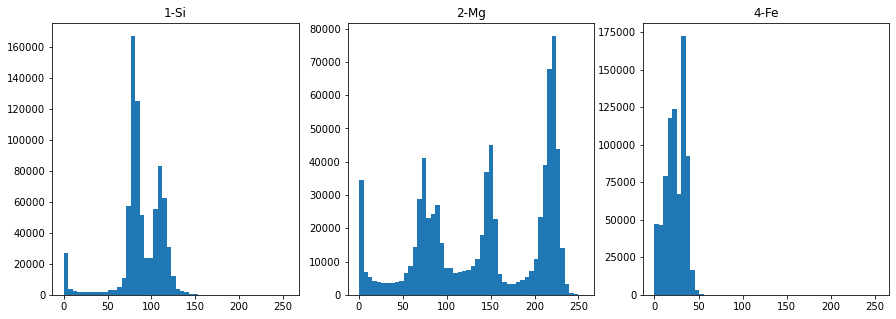

In [6]:
# Create histograms for each element (元素ごとのヒストグラム作成）
fig, ax = plt.subplots(1, len(elements), figsize = (15, 5))
for i, e in enumerate(elements):
    ax[i].hist(flatten_arrays[e], bins=50)
    ax[i].set_title(e)
plt.show()

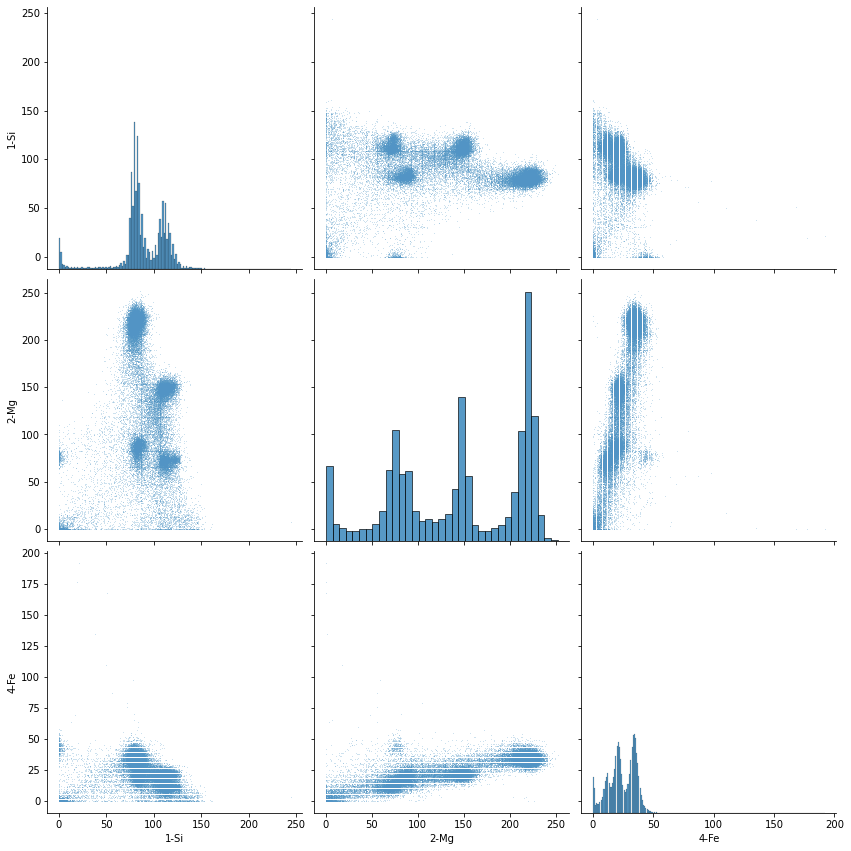

In [7]:
# Create correlation diagrams (相関図作成)
num_sample = np.array([len(df_flat), 50000]).min() # It takes long time while using all the data points, random sampling method is emploied in the case the data points over 50000 (すべての点で描画すると時間がかかるので，データ点が 50000 点より多い場合にはランダムサンプリングをしてから描画)
df_flat = pd.DataFrame(flatten_arrays)
sns.pairplot(df_flat.sample(num_sample), height=4, vars = elements,  plot_kws={"s":1, "alpha": 0.3})

savepath = f"out/{sample_name}/02_pairplot1.jpg"
plt.savefig(savepath)
plt.show()

# Manual definition of threshold (手動で閾値を設定)

In [8]:
# label: [pair of (minimum, maximum) for all elements]
# values should be within 0 to 255
# labels are determined from upper criteria, so mineral with distinct threshold line should be placed uppder.

criteria = {
            'blank': [(0, 25), (0, 10), (0, 5)], # low concentrations
            'Spl': [(0, 255), (60, 95), (35, 60)], # outliers from Mg-Fe correlation trend                                   
            'Ol': [(0, 255), (175, 255), (0, 255)], # highest Mg peak
            'Opx': [(100, 255), (130, 175), (0, 255)], # 2nd Mg peak
            'Cpx': [(50, 95), (60, 110), (0, 255)], # 3rd Mg peak with low Si
            'Grt': [(95, 130), (50, 90), (0, 255)], # 3rd Mg peak with high Si
            }

###########################

# save criteria as csv
df_criteria = pd.DataFrame(criteria, index=elements)
display(df_criteria)
df_criteria.to_csv(f"out/{sample_name}/03_criteria.csv")
print()

# First, label all the data as 0:"unclassified" (まず，すべてのデータを 0:「未分類」とラベル付けする)
type_number = 0
df_flat['type'] = type_number
df_flat['name'] = 'unclassified'

for k, v in criteria.items():
    type_number += 1
    df_temp = df_flat[df_flat['type'] == 0]
    for i, (min, max) in enumerate(v):
        df_temp = df_temp[(df_temp[elements[i]] >= min) & (df_temp[elements[i]] <= max)]
    df_flat.loc[list(df_temp.index), 'name'] = k
    df_flat.loc[list(df_temp.index), 'type'] = type_number

display(df_flat)

,blank,Spl,Ol,Opx,Cpx,Grt
1-Si,"(0, 25)","(0, 255)","(0, 255)","(100, 255)","(50, 95)","(95, 130)"
2-Mg,"(0, 10)","(60, 95)","(175, 255)","(130, 175)","(60, 110)","(50, 90)"
4-Fe,"(0, 5)","(35, 60)","(0, 255)","(0, 255)","(0, 255)","(0, 255)"


,1-Si,2-Mg,4-Fe,type,name
0,1,0,0,1,blank
1,1,0,0,1,blank
2,1,0,0,1,blank
3,1,0,0,1,blank
4,1,0,0,1,blank
...,...,...,...,...,...
767995,92,186,52,3,Ol
767996,89,202,47,3,Ol
767997,90,173,54,0,unclassified
767998,71,186,49,3,Ol


In [9]:
# select color list

# color_list = 'default'
color_list = ['gray', 'black', 'blue', 'red', 'yellow', 'green', 'purple'] # custom: [unlabeled, criteria1, criteria2, ...]

###########
if type(color_list) == list:
    palette = []
    assert len(color_list) >= len(criteria) + 1, f"add more colors"
    for c in color_list:
      if type(c) == str:
          palette.append(mpl.colors.to_rgb(c))
      else:
          palette.append(c)
else:
    palette = sns.color_palette(n_colors=len(criteria) + 1) # use default colors

display(sns.color_palette(palette))

[(0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0),
 (1.0, 0.0, 0.0),
 (1.0, 1.0, 0.0),
 (0.0, 0.5019607843137255, 0.0),
 (0.5019607843137255, 0.0, 0.5019607843137255)]

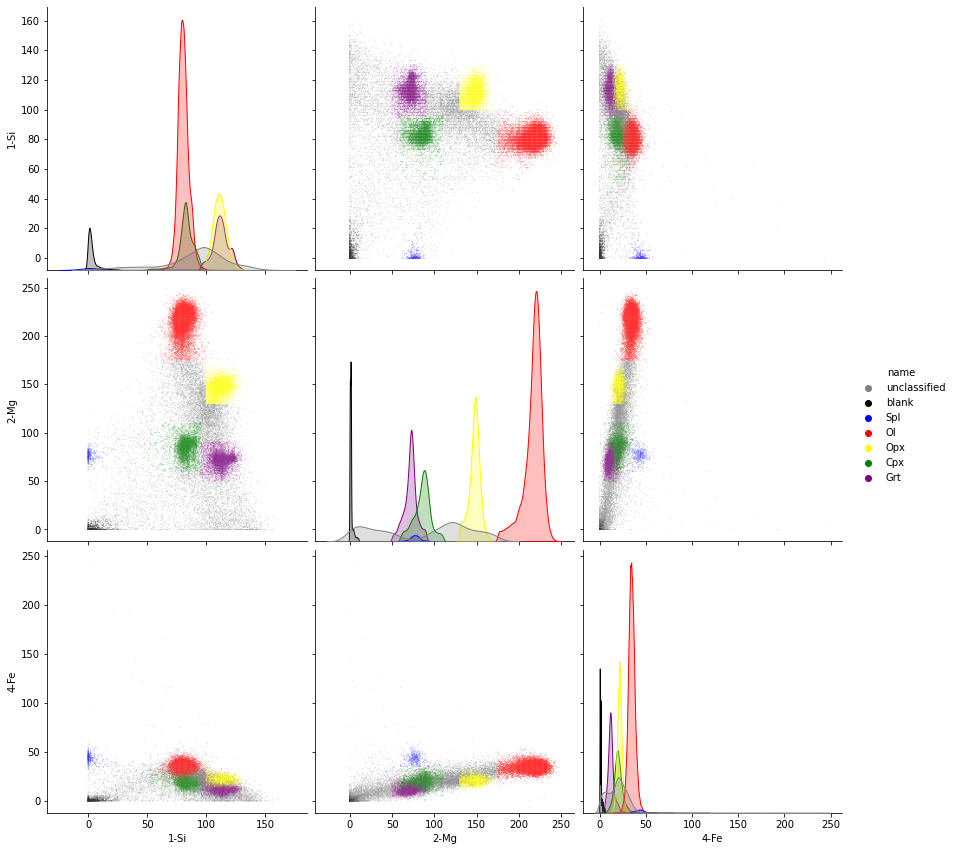

In [10]:
# Create correlation diagrams with colors (色分けした相関図を作成)
num_sample = np.array([len(df_flat), 50000]).min() # It takes long time while using all the data points, random sampling method is emploied in the case the data points over 50000 (すべての点で描画すると時間がかかるので，データ点が 50000 点より多い場合にはランダムサンプリングをしてから描画)
sns.pairplot(df_flat.sample(num_sample), height=4, vars = elements, hue="name", 
             palette = palette, hue_order = ['unclassified'] + list(criteria.keys()), 
             plot_kws={"s":1, "alpha": 0.3})
savepath = f"out/{sample_name}/04_pairplot2.jpg"
plt.savefig(savepath)
plt.show()

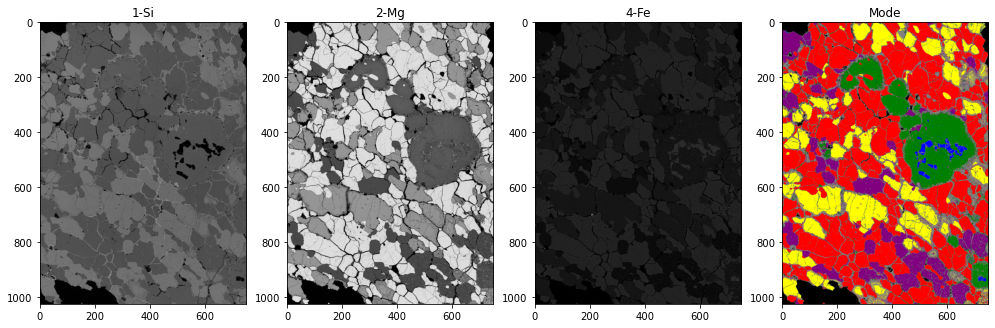

In [11]:
# Create modal image for comparison with the raw images (元画像との比較)
# Acquire data and display as modal image (データを取得して画像で表示)
fig, ax = plt.subplots(1, len(elements) + 1, figsize = (17, 7))

for i, e in enumerate(elements):
    img_path = f"data/{sample_name}/{e}{ext}"
    assert os.path.exists(img_path), f"path not exists: {img_path}"
    img = cv2.imread(img_path)
    ax[i].imshow(img)
    ax[i].set_title(e)
    ax[i].set_aspect('equal')

mode = np.zeros_like(cv2.imread(img_path))
mode_k = np.array(df_flat['type']).reshape(mode.shape[:2])

for i, p in enumerate(palette):
    mode[mode_k == i] = (np.array(p) * 255)

ax[len(elements)].imshow(mode)
ax[len(elements)].set_title('Mode')

# Save modal image (モード組成画像を保存)
imsave(f"out/{sample_name}/05_mode.jpg", mode)

# Export modal image in in the side of the elemental distribution images (元素マップと並べて書き出し)
savepath = f"out/{sample_name}/06_mode_withMap.jpg"
plt.savefig(savepath)
plt.show()

In [12]:
# Output modal compositions (面積割合の算出)
invalid_criteria_keys = ['blank', 'unclassified'] # Criteria NOT included in denominator (分母に含めないクライテリア)

##############################

valid_criteria_keys = [k for k in criteria.keys() if k not in invalid_criteria_keys]
print('valid criteria: ', valid_criteria_keys)

df_result = pd.DataFrame([])

num_valid = np.sum(df_flat['name'].isin(valid_criteria_keys))
for k in (['unclassified'] + list(criteria.keys())):
    df_result.loc[k, 'pixels'] = np.sum(df_flat['name'] == k)
    if k in valid_criteria_keys:
        df_result.loc[k, 'ratio_%'] = np.sum(df_flat['name'] == k) / num_valid * 100

pd.options.display.precision = 2
df_result['pixels'] = df_result['pixels'].astype(int)
display(df_result)
df_result.to_csv(f"out/{sample_name}/07_result.csv")

valid criteria:  ['Spl', 'Ol', 'Opx', 'Cpx', 'Grt']


,pixels,ratio_%
unclassified,127859,NaN
blank,25710,NaN
Spl,6061,0.99
Ol,304439,49.55
Opx,122785,19.98
Cpx,88649,14.43
Grt,92497,15.05
